In [ ]:
import cv2
from PIL import Image
import numpy as np

In [ ]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [ ]:
def mask_image(img):
    width, height = img.shape[1], img.shape[0]
    padding = 30
    min_size = 30
    max_size = 80

    box_width = np.random.randint(min_size, max_size)
    box_height = np.random.randint(min_size, max_size)

    anchor = np.random.randint(0+padding, width - padding - box_width), np.random.randint(0+padding, height - padding - box_height)


    img[anchor[1]:anchor[1]+box_height, anchor[0]:anchor[0]+box_width, :] = 0

    return img

In [ ]:
img = cv2.imread('../.images/test_256/Places365_test_00003209.jpg')

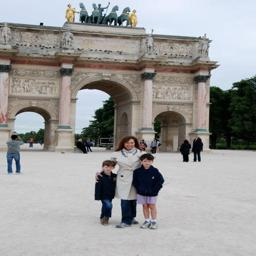

In [ ]:
imshow(img)

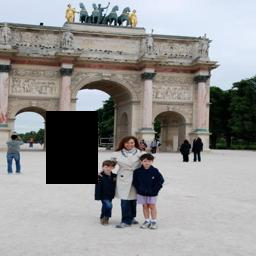

In [ ]:
imshow(mask_image(img.copy()))

In [9]:
from pathlib import Path

files = np.array(list((Path("../.images/test_256").glob("*.jpg"))))

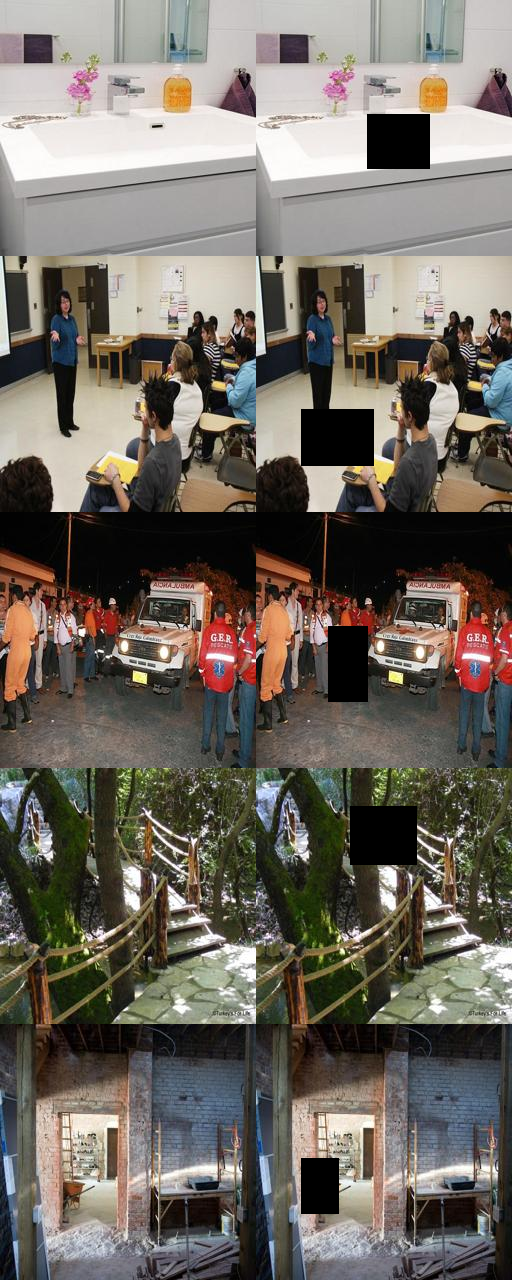

In [ ]:
imgs = None
masks = None
for file in np.random.choice(files, size=5, replace=False):
    img = cv2.imread(file)
    assert img is not None, "Image not found"

    masked = mask_image(img.copy())
    imgs = np.concatenate([imgs, img], axis=0) if imgs is not None else img
    masks = np.concatenate([masks, masked], axis=0) if masks is not None else masked

imshow(np.concatenate([imgs, masks], axis=1))

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import decode_image
from utils.tensor import numpy_to_tensor, tensor_to_numpy
from utils.notebook import imshow
from utils.masking import mask_image

In [23]:
from torchvision.transforms.v2 import RGB

In [73]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = decode_image(img_path)
        img = RGB()(img) # some images were in grayscale (417, 738, ...)
        if self.transform:
            img = self.transform(img)
        return img
    
    def get_filename(self, idx):
        return self.img_names[idx]

    def show_image(self, idx):
        img = self.__getitem__(idx)
        img_np = tensor_to_numpy(img)
        img_np[:, :, [0, 1, 2]] = img_np[:, :, [2, 1, 0]] # convert RGB to BGR
        imshow(img_np)

In [40]:
dataset = ImageDataset('../.images/test_256')

In [129]:
dl = DataLoader(dataset, batch_size=64, shuffle=True)

In [45]:
def mask_batch(batch):
    masked_batch = []
    for img in batch:
        img_np = tensor_to_numpy(img)
        masked_img_np = mask_image(img_np)
        masked_img = numpy_to_tensor(masked_img_np)
        masked_batch.append(masked_img)
    return torch.stack(masked_batch)

In [46]:
def mask_image(img: np.ndarray) -> np.ndarray:
    width, height = img.shape[1], img.shape[0]
    padding = 30
    min_size = 30
    max_size = 80

    box_width = np.random.randint(min_size, max_size)
    box_height = np.random.randint(min_size, max_size)

    anchor = np.random.randint(0+padding, width - padding - box_width), np.random.randint(0+padding, height - padding - box_height)


    img[anchor[1]:anchor[1]+box_height, anchor[0]:anchor[0]+box_width, :] = 0

    return img

In [47]:
def mask_tensor(img: torch.Tensor) -> torch.Tensor:
    width, height = img.shape[2], img.shape[1]
    padding = 30
    min_size = 30
    max_size = 80

    box_width = np.random.randint(min_size, max_size)
    box_height = np.random.randint(min_size, max_size)

    anchor = np.random.randint(0+padding, width - padding - box_width), np.random.randint(0+padding, height - padding - box_height)

    img[:, anchor[1]:anchor[1]+box_height, anchor[0]:anchor[0]+box_width] = 0
    return img

In [48]:
def mask_batch2(batch):
    masked_batch = []
    for img in batch:
        masked_img = mask_tensor(img)
        masked_batch.append(masked_img)
    return torch.stack(masked_batch)

In [ ]:
def mask_batch3(batch: torch.Tensor) -> torch.Tensor:
    masked_batch = batch.clone()
    batch_size, channels, height, width = batch.shape
    padding = 30
    min_size = 30
    max_size = 80

    for i in range(batch_size):
        box_width = np.random.randint(min_size, max_size)
        box_height = np.random.randint(min_size, max_size)

        anchor = np.random.randint(0+padding, width - padding - box_width), np.random.randint(0+padding, height - padding - box_height)

        masked_batch[i, :, anchor[1]:anchor[1]+box_height, anchor[0]:anchor[0]+box_width] = 0

    return masked_batch

In [100]:
def mask_batch3_optimized(batch: torch.Tensor) -> torch.Tensor:
    masked_batch = batch.clone()
    batch_size, channels, height, width = batch.shape
    padding = 30
    min_size = 30
    max_size = 80

    # Pre-generate all random values at once using torch (faster than numpy)
    box_widths = torch.randint(min_size, max_size, (batch_size,), device=batch.device)
    box_heights = torch.randint(min_size, max_size, (batch_size,), device=batch.device)
    anchor_x = torch.randint(padding, width - padding - min_size, (batch_size,), device=batch.device)
    anchor_y = torch.randint(padding, height - padding - min_size, (batch_size,), device=batch.device)

    # Apply masks using pre-computed random values
    for i in range(batch_size):
        x1, y1 = anchor_x[i].item(), anchor_y[i].item()
        x2 = x1 + box_widths[i].item()
        y2 = y1 + box_heights[i].item()
        masked_batch[i, :, y1:y2, x1:x2] = 0

    return masked_batch

In [50]:
import time

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [200]:
for batch in dl:
    times = {1: None, 2: None, 3: None, '3_opt': None}
    batch_copy = batch.clone()
    batch_copy.to(device)
    start = time.time_ns()
    masked_batch = mask_batch(batch_copy)
    print(masked_batch.shape)
    # for img in masked_batch:
        # imshow(tensor_to_numpy(img, bgr=True))
    print(f"Time taken: {(time.time_ns() - start)/1e6} ms")
    times[1] = (time.time_ns() - start)/1e6

    batch_copy = batch.clone()
    batch_copy.to(device)
    start = time.time_ns()
    masked_batch = mask_batch2(batch_copy)
    print(masked_batch.shape)
    print(f"Time taken: {(time.time_ns() - start)/1e6} ms")
    times[2] = (time.time_ns() - start)/1e6
    
    batch_copy = batch.clone()
    batch_copy.to(device)
    start = time.time_ns()
    masked_batch = mask_batch3(batch_copy)
    print(masked_batch.shape)
    print(f"Time taken: {(time.time_ns() - start)/1e6} ms")
    times[3] = (time.time_ns() - start)/1e6

    batch_copy = batch.clone()
    batch_copy.to(device)
    start = time.time_ns()
    masked_batch = mask_batch3_optimized(batch_copy)
    print(masked_batch.shape)
    print(f"Time taken: {(time.time_ns() - start)/1e6} ms")
    times['3_opt'] = (time.time_ns() - start)/1e6

    print(times)
    print(min(times, key=times.get), "is the fastest method.")
    break

torch.Size([64, 3, 256, 256])
Time taken: 29.5447 ms
torch.Size([64, 3, 256, 256])
Time taken: 5.9361 ms
torch.Size([64, 3, 256, 256])
Time taken: 3.798 ms
torch.Size([64, 3, 256, 256])
Time taken: 5.4862 ms
{1: 29.5642, 2: 5.9488, 3: 3.8118, '3_opt': 5.5072}
3 is the fastest method.


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

IMG_SIZE = 256

val_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder('../images', transform=val_transforms)

In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from torch.utils.data import DataLoader
dl = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
from utils.masking import generate_batch_masks, mask_batch_torch

In [16]:
batch = next(iter(dl))[0].to(device)

In [19]:
batch.size(), batch.device

(torch.Size([32, 3, 256, 256]), device(type='cuda', index=0))

In [22]:
masks= generate_batch_masks(batch, device)

In [26]:
masked = mask_batch_torch(batch, masks, device)

In [25]:
from utils.notebook import display_batch

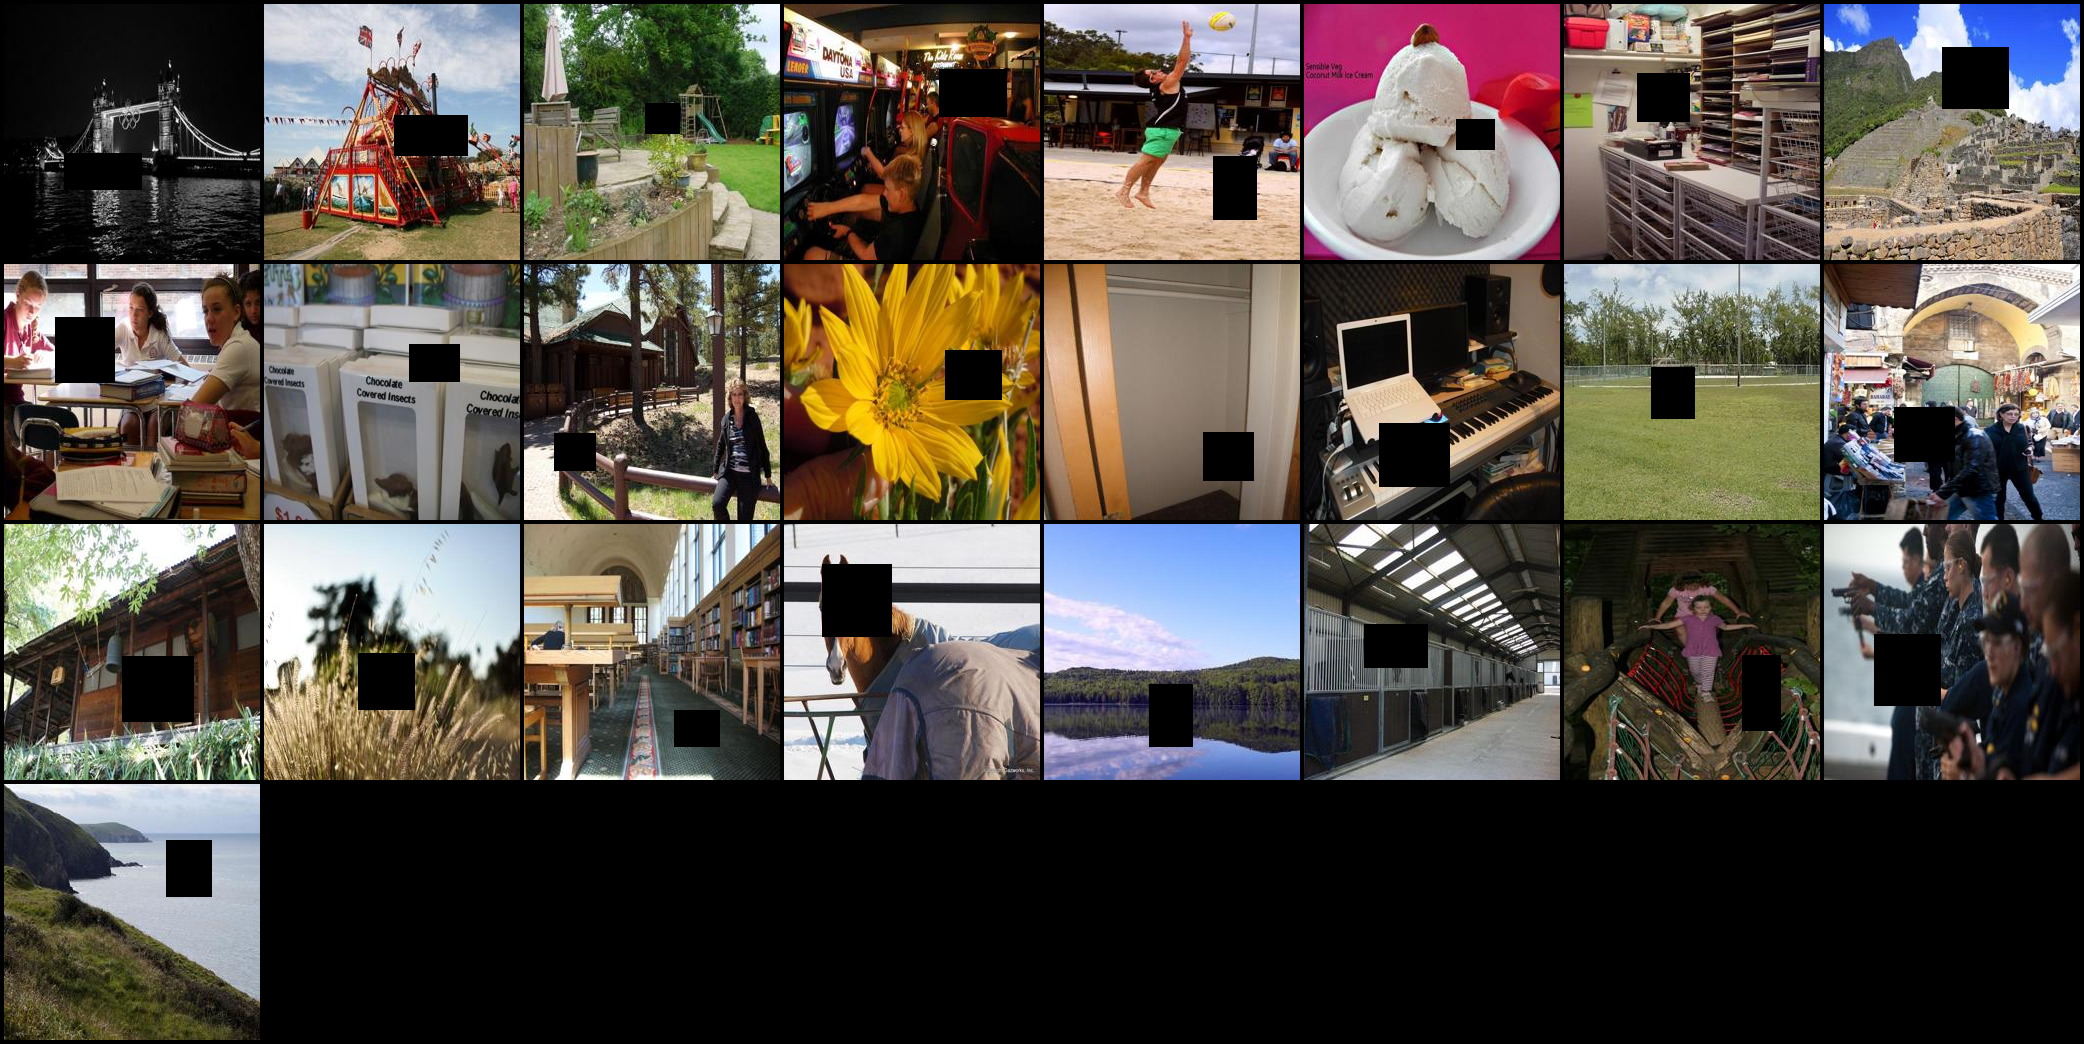

In [27]:
display_batch(masked)

In [29]:
from utils.notebook import reload_module

In [44]:
get_batch_masks = reload_module(get_batch_masks)

In [31]:
from utils.masking import get_batch_masks

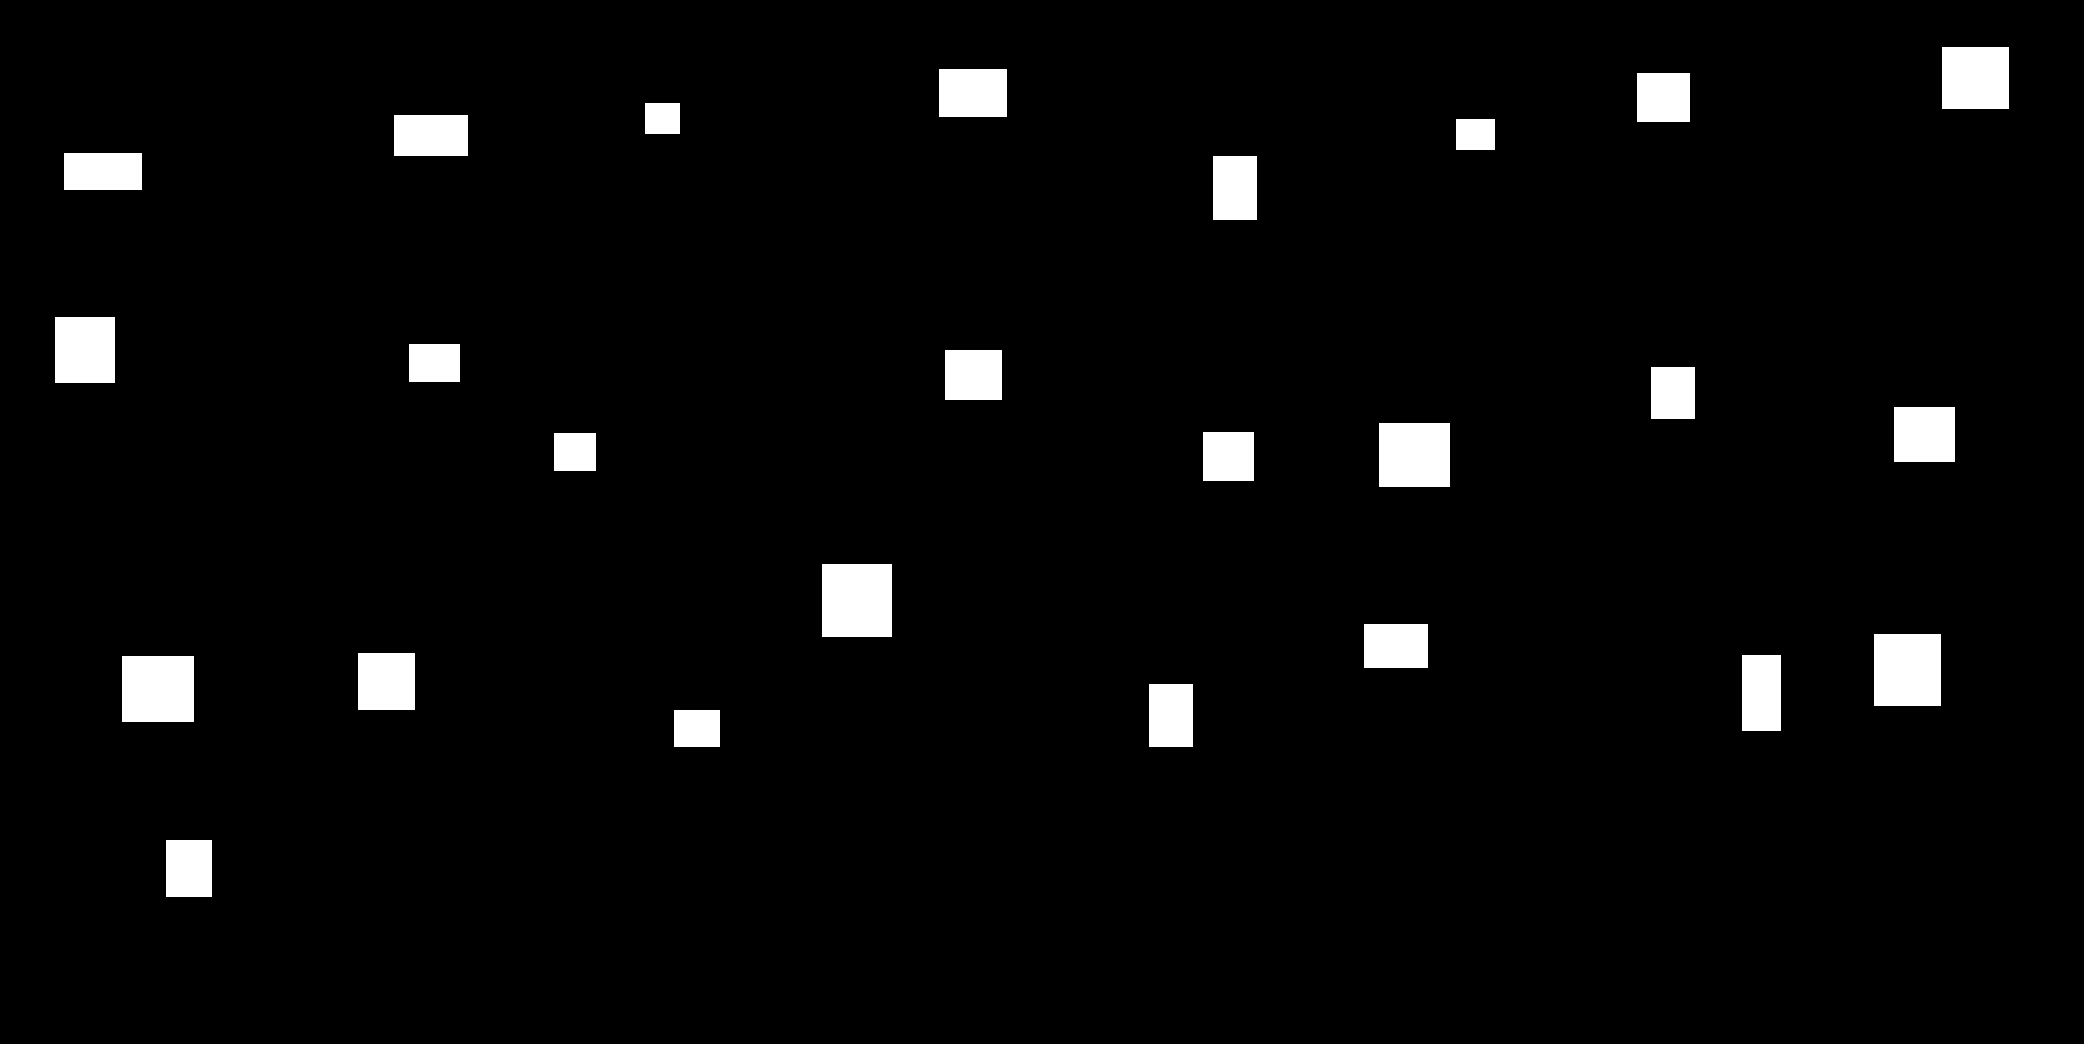

In [36]:
display_batch(get_batch_masks(batch, masks, device))

In [45]:
from utils.masking import generate_batch_masks, get_mask_channel, overlay_masks

In [48]:
masks = generate_batch_masks(batch, device)
mask_channel = get_mask_channel(batch, masks, device)
masked_real = overlay_masks(batch, masks, device)
masked = torch.cat((masked_real, mask_channel), dim=1)

In [43]:
mask_channel.shape

torch.Size([32, 3, 256, 256])